Can experience and age predict hours played?

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [4]:
players <- read_csv('players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
players_tidy <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),) |>
    # filter(100 > played_hours) |>
    select(experience, Age, played_hours)
players_tidy

experience,Age,played_hours
<dbl>,<dbl>,<dbl>
5,9,30.3
4,17,3.8
4,17,0.0
2,21,0.7
3,21,0.1
2,17,0.0
3,19,0.0
2,21,0.0
2,17,0.1


In [38]:
experience_playtime_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_player_hours = mean(played_hours))
experience_playtime_means

experience,mean_player_hours
<dbl>,<dbl>
1,1.2485714
2,6.0174603
3,18.7257143
4,0.6479167
5,2.7846154


In [39]:
experience_age_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_age = mean(Age))
experience_age_means

experience,mean_age
<dbl>,<dbl>
1,21.65714
2,20.25397
3,20.60000
4,20.95833
5,16.92308


In [40]:
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [41]:
players_recipe <- recipe(played_hours ~ experience + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold = vfold_cv(players_train, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [42]:
gridvals <- tibble(neighbors = seq(from = 1, to = 64, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.88889,5,6.731980,Preprocessor1_Model01
2,rmse,standard,32.25394,5,6.011718,Preprocessor1_Model02
3,rmse,standard,31.40083,5,5.891993,Preprocessor1_Model03
4,rmse,standard,28.31066,5,6.163369,Preprocessor1_Model04
5,rmse,standard,29.64480,5,5.685115,Preprocessor1_Model05
6,rmse,standard,29.09178,5,5.786629,Preprocessor1_Model06
7,rmse,standard,28.93798,5,6.157093,Preprocessor1_Model07
8,rmse,standard,28.22183,5,5.798753,Preprocessor1_Model08
9,rmse,standard,29.13155,5,6.176177,Preprocessor1_Model09


In [43]:
players_min <- players_results |>
    filter(mean == min(mean))
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,26.93014,5,5.936286,Preprocessor1_Model31


In [44]:
players_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 31) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,21.91265


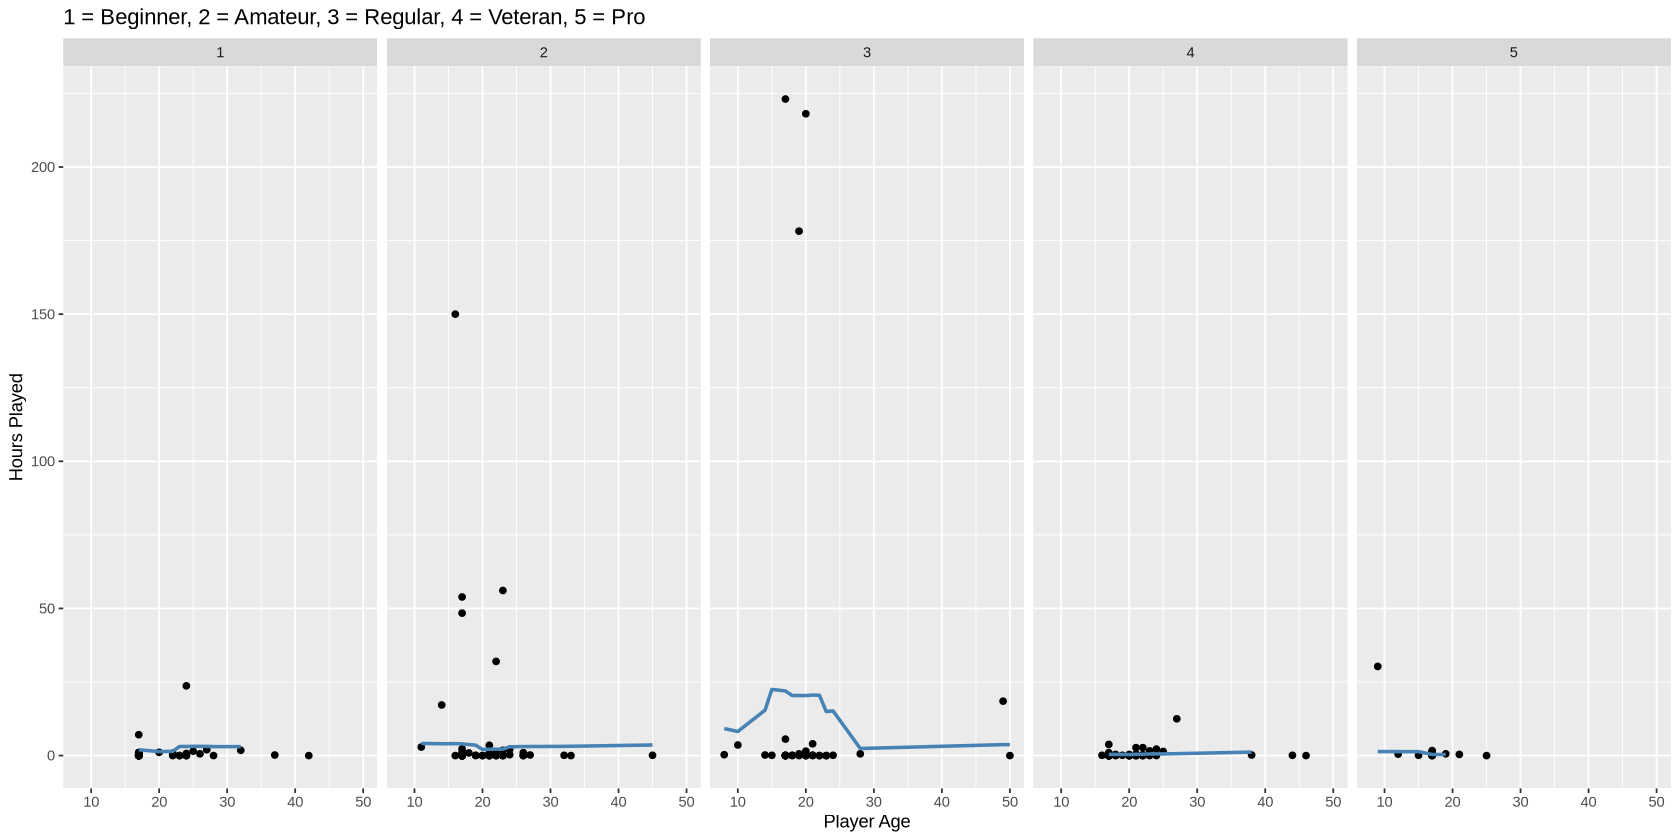

In [46]:
players_preds <- predict(players_fit, players_train) |>
        bind_cols(players_train)

options(repr.plot.width = 14, repr.plot.height = 7)

players_plot <- ggplot(players_tidy, aes(x = Age, y = played_hours)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played") +
    ggtitle('1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro')

players_plot + facet_wrap(~experience, ncol = 5)

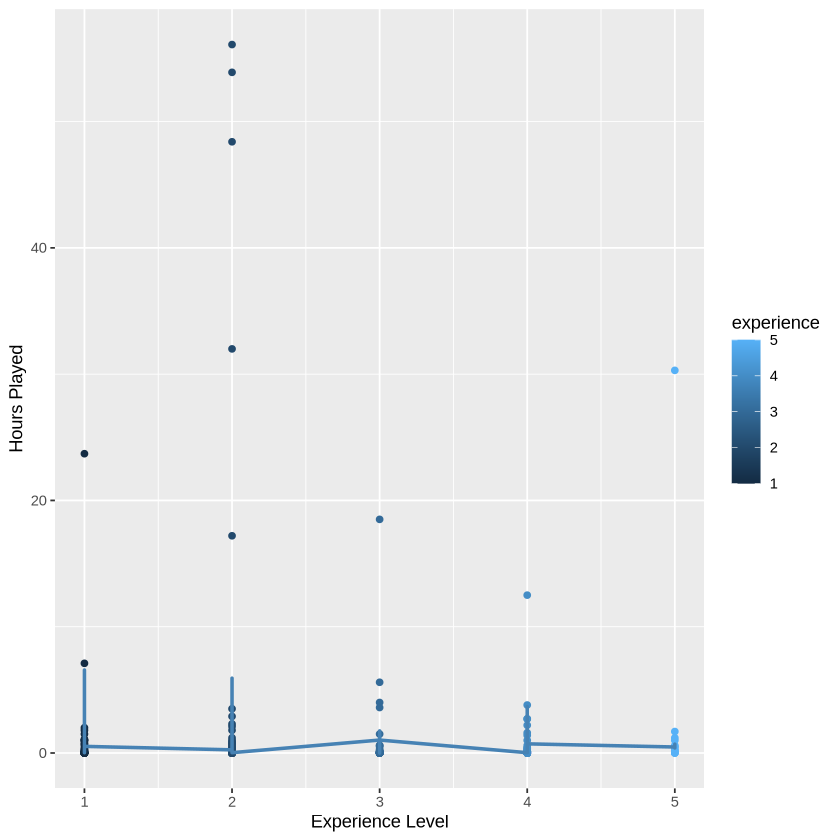

In [25]:
players_experience_plot <- ggplot(players_tidy, aes(x = experience, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = experience, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Experience Level") +
  ylab("Hours Played")

players_experience_plot

In [27]:
?facet_wrap

facet_wrap {ggplot2},R Documentation
facets,"A set of variables or expressions quoted by vars() and defining faceting groups on the rows or columns dimension. The variables can be named (the names are passed to labeller). For compatibility with the classic interface, can also be a formula or character vector. Use either a one sided formula, ~a + b, or a character vector, c(""a"", ""b"")."
"nrow, ncol",Number of rows and columns.
scales,"Should scales be fixed (""fixed"", the default), free (""free""), or free in one dimension (""free_x"", ""free_y"")?"
shrink,"If TRUE, will shrink scales to fit output of statistics, not raw data. If FALSE, will be range of raw data before statistical summary."
labeller,"A function that takes one data frame of labels and returns a list or data frame of character vectors. Each input column corresponds to one factor. Thus there will be more than one with vars(cyl, am). Each output column gets displayed as one separate line in the strip label. This function should inherit from the ""labeller"" S3 class for compatibility with labeller(). You can use different labeling functions for different kind of labels, for example use label_parsed() for formatting facet labels. label_value() is used by default, check it for more details and pointers to other options."
as.table,"If TRUE, the default, the facets are laid out like a table with highest values at the bottom-right. If FALSE, the facets are laid out like a plot with the highest value at the top-right."
switch,"By default, the labels are displayed on the top and right of the plot. If ""x"", the top labels will be displayed to the bottom. If ""y"", the right-hand side labels will be displayed to the left. Can also be set to ""both""."
drop,"If TRUE, the default, all factor levels not used in the data will automatically be dropped. If FALSE, all factor levels will be shown, regardless of whether or not they appear in the data."
dir,"Direction: either ""h"" for horizontal, the default, or ""v"", for vertical."
strip.position,"By default, the labels are displayed on the top of the plot. Using strip.position it is possible to place the labels on either of the four sides by setting strip.position = c(""top"", ""bottom"", ""left"", ""right"")"


In [26]:
players_preds |>
    arrange(Age)

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
1.750,3,8,0.3
1.750,3,10,3.6
5.925,2,11,2.9
0.400,5,12,0.5
0.050,3,14,0.2
5.025,2,14,17.2
0.700,5,15,0.1
0.050,4,16,0.1
0.025,2,16,0.0


In [14]:
regulars <- players_tidy |>
    filter(experience == 'Regular')

regulars_split <- initial_split(regulars, prop = 0.75, strata = played_hours)
regulars_train <- training(regulars_split)
regulars_test <- testing(regulars_split)

regulars_recipe <- recipe(played_hours ~ Age, data = regulars_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

regulars_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

regulars_vfold = vfold_cv(regulars_train, v = 5, strata = played_hours)

regulars_workflow <- workflow() |>
    add_recipe(regulars_recipe) |>
    add_model(regulars_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))

regulars_results <- regulars_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
regulars_min <- regulars_results |>
    filter(mean == min(mean))
regulars_min

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,rmse,standard,30.24068,5,8.138825,Preprocessor1_Model12


In [15]:
regulars

experience,Age,played_hours
<fct>,<dbl>,<dbl>
Regular,21,0.1
Regular,19,0.0
Regular,19,0.6
Regular,8,0.3
Regular,28,0.6
Regular,17,0.0
Regular,17,5.6
Regular,23,0.0
Regular,20,218.1


In [16]:
players_real <- players_tidy |>
    filter(played_hours != 0)

players_real_split <- initial_split(players_real, prop = 0.75, strata = played_hours)
players_real_train <- training(players_real_split)
players_real_test <- testing(players_real_split)

players_real_recipe <- recipe(played_hours ~ Age, data = players_real_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_real_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_vfold = vfold_cv(players_real_train, v = 5, strata = played_hours)

players_real_workflow <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 32, by = 1))

players_real_results <- players_real_workflow |>
  tune_grid(resamples = players_real_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_real_min <- players_real_results |>
    filter(mean == min(mean))
players_real_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,28.12591,5,12.78355,Preprocessor1_Model17


In [17]:
players_real_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 24) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_fit <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec) |>
    fit(data = players_real_train)

players_real_summary <- players_real_fit |>
  predict(players_real_test) |>
  bind_cols(players_real_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_real_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,41.40788


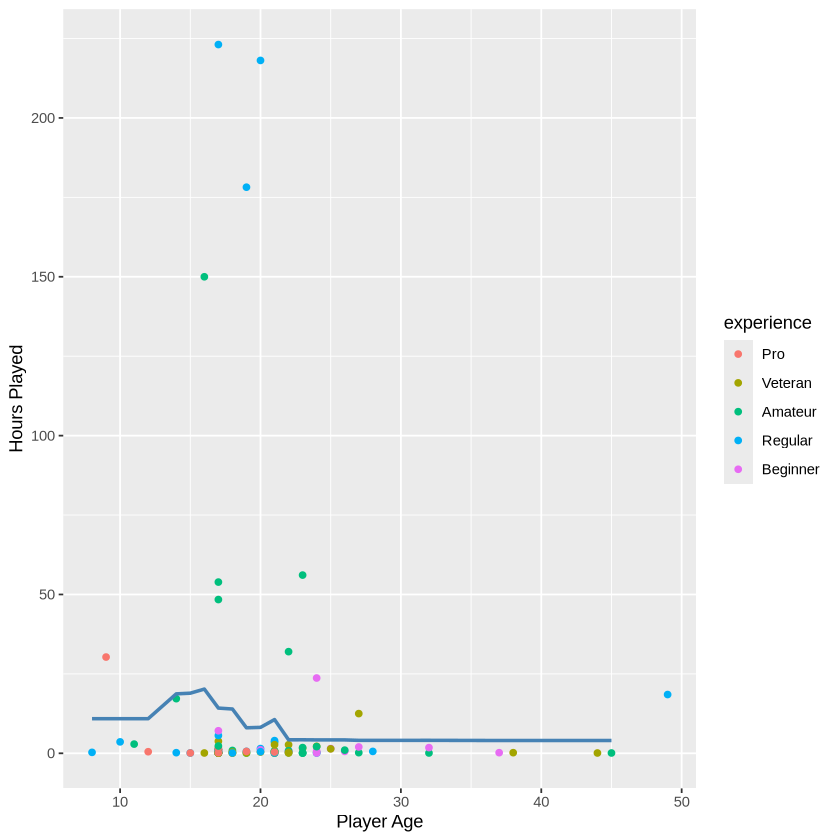

In [18]:
players_real_preds <- predict(players_real_fit, players_real_train) |>
        bind_cols(players_real_train)

players_real_plot <- ggplot(players_real, aes(x = Age, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_real_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played")

players_real_plot

In [19]:
players_real_preds |>
    arrange(Age)

.pred,experience,Age,played_hours
<dbl>,<fct>,<dbl>,<dbl>
10.90000,Regular,8,0.3
10.90000,Pro,9,30.3
10.90000,Regular,10,3.6
10.90000,Amateur,11,2.9
10.90000,Pro,12,0.5
18.71250,Amateur,14,17.2
18.92500,Regular,15,0.1
18.92500,Pro,15,0.1
20.21667,Amateur,16,150.0
